# LightGBM

__Задание 1:__ сделать __Hold-Out__ валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции __(TransactionID)__, обучать модель градиетного бустинга любой реализации с подбором числа деревьев по __early_stopping__ критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на __ЛБ__, сравнить с качеством на обучении и валидации. Сделать выводы.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import category_encoders as ce
from sklearn import metrics
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import warnings
from tqdm import tqdm
from typing import List, Tuple


warnings.simplefilter("ignore")
matplotlib.rcParams['figure.figsize'] = 10, 6
pd.options.display.max_columns=202
pd.options.display.max_rows=202

In [2]:
def show_results(model, train_cleaned, y_train, valid_cleaned, y_valid, 
                 lb_cleaned, target_lb, test_cleaned = None, y_test = None):
    
    ypred_train = model.predict(train_cleaned)
    ypred_valid = model.predict(valid_cleaned)
    if test_cleaned is not None:
        ypred_test  = model.predict(test_cleaned )
    ypred_lb  = model.predict(lb_cleaned )

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, ypred_train, pos_label=1)
    fpr_valid, tpr_valid, thresholds_valid = metrics.roc_curve(y_valid, ypred_valid, pos_label=1)
    if test_cleaned is not None:
        fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, ypred_test, pos_label=1)
    fpr_lb, tpr_lb, thresholds_lb = metrics.roc_curve(target_lb, ypred_lb, pos_label=1)

    plt.plot(fpr_train, tpr_train, label='train')
    plt.plot(fpr_valid, tpr_valid, label='valid')
    if test_cleaned is not None:
        plt.plot(fpr_test, tpr_test, c="blue", label='test')
    plt.plot(fpr_lb, tpr_lb, c="red", label='lb')
    plt.legend()

    train_roc_auc = roc_auc_score(y_train, ypred_train)
    valid_roc_auc = roc_auc_score(y_valid, ypred_valid)
    if test_cleaned is not None:
        test_roc_auc  = roc_auc_score(y_test , ypred_test)
    lb_roc_auc  = roc_auc_score(target_lb , ypred_lb)
    print('train_roc_auc:', train_roc_auc)
    print('valid_roc_auc:', valid_roc_auc)
    if test_cleaned is not None:
        print('test_roc_auc :', test_roc_auc)
    print('lb_roc_auc   :', lb_roc_auc)

In [3]:
df_train = pd.read_csv("data/assignment_2_train.csv")
lb__board = pd.read_csv("data/assignment_2_test.csv")
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*lb__board.shape))
df_train.head(n=2)

df_train.shape = 180000 rows, 394 cols
df_test.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,...,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_train = df_train.sort_values(by=['TransactionID'])
target_train = df_train["isFraud"]
target_lb    = lb__board["isFraud"]

In [5]:
train = df_train.drop(["TransactionID", "isFraud"], axis=1)
lb    = lb__board.drop(["TransactionID", "isFraud"], axis=1)
print("train.shape = {} rows, {} cols".format(*train.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))

df_numerical_features = train.select_dtypes(include=[np.number])
numerical_features = df_numerical_features.columns
category_features  = [i for i in train.columns if i not in numerical_features]

df_train.head(7)

train.shape = 180000 rows, 392 cols
lb.shape = 100001 rows, 392 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,...,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [6]:
X_train = train[:135000]
X_valid = train[135000:]
y_train = target_train[:135000]
y_valid = target_train[135000:]

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": 7,
    "seed": 27
}

In [7]:
encoder = ce.HelmertEncoder(cols=category_features)
encoder.fit(X_train, y_train)
train_cleaned = encoder.transform(X_train)
valid_cleaned = encoder.transform(X_valid)

lb_cleaned  = encoder.transform(lb)

dtrain = lgb.Dataset(
    data=train_cleaned, label=y_train
)
dvalid = lgb.Dataset(
    data=valid_cleaned,  label=y_valid
)

In [8]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.87937	valid_1's auc: 0.856428
[100]	training's auc: 0.902945	valid_1's auc: 0.866408
[150]	training's auc: 0.91494	valid_1's auc: 0.870416
[200]	training's auc: 0.922286	valid_1's auc: 0.875523
[250]	training's auc: 0.92939	valid_1's auc: 0.880189
[300]	training's auc: 0.937121	valid_1's auc: 0.887088
[350]	training's auc: 0.944002	valid_1's auc: 0.892386
[400]	training's auc: 0.949436	valid_1's auc: 0.896222
[450]	training's auc: 0.954155	valid_1's auc: 0.899265
[500]	training's auc: 0.958298	valid_1's auc: 0.902367
[550]	training's auc: 0.962107	valid_1's auc: 0.904662
[600]	training's auc: 0.965085	valid_1's auc: 0.906629
[650]	training's auc: 0.96766	valid_1's auc: 0.908887
[700]	training's auc: 0.970151	valid_1's auc: 0.909977
[750]	training's auc: 0.97233	valid_1's auc: 0.910694
[800]	training's auc: 0.974234	valid_1's auc: 0.911449
[850]	training's auc: 0.975935	valid_1's auc: 0.912038
[900]	trai

train_roc_auc: 0.9882920164094144
valid_roc_auc: 0.9164128039668522
lb_roc_auc   : 0.870773825098463


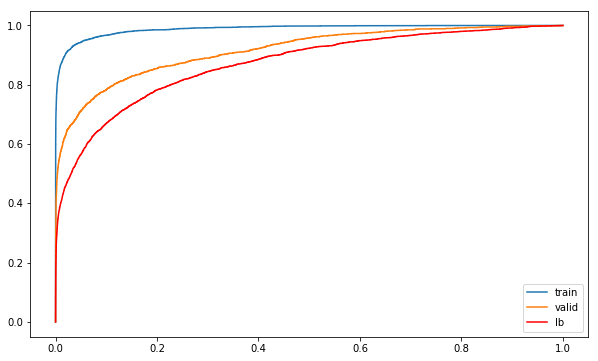

In [9]:
show_results(model, train_cleaned, y_train, valid_cleaned, y_valid, 
                 lb_cleaned, target_lb, test_cleaned = None, y_test = None)

__Выводы:__   
Разница между __valid_roc_auc__ и __lb_roc_auc__ примерно 4% - что вероятно на грани приемлемого.  
Разница между __train_roc_auc__ и __valid_roc_auc__ примерно 7% - что вероятно говорит об излишней чувствительности модели.


__Задание 2:__ сделать __Hold-Out__ валидацию с разбиением на __3__ выборки, разбиение проводить по id-транзакции __(TransactionID)__, размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [10]:
X_train = train[:90000]
X_valid = train[90000:135000]
X_test  = train[135000:]

y_train = target_train[:90000]
y_valid = target_train[90000:135000]
y_test  = target_train[135000:]



encoder = ce.HelmertEncoder(cols=category_features)
encoder.fit(X_train, y_train)
train_cleaned = encoder.transform(X_train)
valid_cleaned = encoder.transform(X_valid)

test_cleaned  = encoder.transform(X_test)
lb_cleaned  = encoder.transform(lb)

dtrain = lgb.Dataset(
    data=train_cleaned, label=y_train
)
dvalid = lgb.Dataset(
    data=valid_cleaned,  label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.886111	valid_1's auc: 0.855017
[100]	training's auc: 0.905863	valid_1's auc: 0.870019
[150]	training's auc: 0.92006	valid_1's auc: 0.875315
[200]	training's auc: 0.930021	valid_1's auc: 0.880262
[250]	training's auc: 0.939539	valid_1's auc: 0.882795
[300]	training's auc: 0.946796	valid_1's auc: 0.885988
[350]	training's auc: 0.953387	valid_1's auc: 0.888346
[400]	training's auc: 0.959607	valid_1's auc: 0.890695
[450]	training's auc: 0.965177	valid_1's auc: 0.892827
[500]	training's auc: 0.969162	valid_1's auc: 0.89464
[550]	training's auc: 0.972955	valid_1's auc: 0.895434
[600]	training's auc: 0.976291	valid_1's auc: 0.896031
[650]	training's auc: 0.978837	valid_1's auc: 0.896521
[700]	training's auc: 0.98076	valid_1's auc: 0.897289
[750]	training's auc: 0.982632	valid_1's auc: 0.898084
[800]	training's auc: 0.984339	valid_1's auc: 0.898508
[850]	training's auc: 0.985721	valid_1's auc: 0.89881
[900]	tra

train_roc_auc: 0.9894473008561843
valid_roc_auc: 0.8999119086997956
test_roc_auc : 0.88832504415161
lb_roc_auc   : 0.8582871454189362


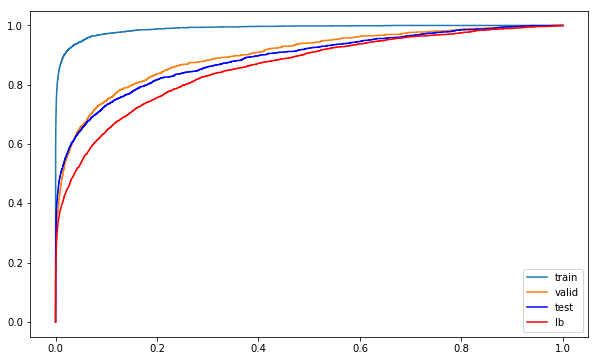

In [11]:
show_results(model, train_cleaned, y_train, valid_cleaned, y_valid, 
                 lb_cleaned, target_lb, test_cleaned = test_cleaned, y_test = y_test)


__Выводы:__   
Значения __valid_roc_auc__ и __test_roc_auc__ примерно равны. Из этого можно, с некоторой долей вероятности, сделать заключение о том что модель уверенно выучила закономерности тренировочного набора данных. Но так как оба показателя __valid_roc_auc__ и __test_roc_auc__ примернно на 4% отличаются от __lb_roc_auc__ можно предположить что в данных лидерборда мы имеем несколько другое их распределение.  
Разница между __train_roc_auc__ и __valid_roc_auc__ примерно 10% - что явно говорит об излишней чувствительности модели.


__Задание 3:__ построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [12]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [13]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(test_cleaned), roc_auc_score)

calculate_confidence_interval(scores)

(0.8785609021473367, 0.8979300312753381)

In [14]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_valid, model.predict(valid_cleaned), roc_auc_score)

calculate_confidence_interval(scores)

(0.8892420491663692, 0.9105860536901108)

__Выводы:__ 

Оценки посчитанных доверительных интервалов __слишком оптимистичны__. Результат модели на лидерборд ниже нижней границы доверительных интервалов...(0.8582871454189362 против 0.8785609021473367 и 0.8892420491663692)

__Задание 4:__ выполнить __Adversarial Validation__, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [15]:
train_adv = df_train.copy()
lb_adv = lb__board.copy()

# Уберем "TransactionDT" так как этот признак однозначно разделякт трейн и тест...
train_adv = train_adv.drop(["TransactionDT", "TransactionID", "isFraud"], axis=1)
lb_adv = lb_adv.drop(["TransactionDT", "TransactionID", "isFraud"], axis=1)

df_numerical_features = train_adv.select_dtypes(include=[np.number])
numerical_features = df_numerical_features.columns



x_adv = pd.concat([
    train_adv, lb_adv], axis=0
)
y_adv = np.hstack((np.zeros(train_adv.shape[0]), np.ones(lb_adv.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]


dtrain = lgb.Dataset(
    data=x_adv[numerical_features], label=y_adv
)


model_adv_test = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature="auto"
)

In [16]:
y_pred_adv = model_adv_test.predict(x_adv[numerical_features])
score = roc_auc_score(y_adv, y_pred_adv)
print(round(score, 4))

0.9094


In [17]:
y_pred = model_adv_test.predict(train_adv[numerical_features])
y_pred

array([0.20715883, 0.32018808, 0.11080242, ..., 0.97106452, 0.07635847,
       0.08994768])

In [18]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    53571
(0.1, 0.2]    71513
(0.2, 0.3]    19884
(0.3, 0.4]    16187
(0.4, 0.5]    11202
(0.5, 0.6]     6027
(0.6, 0.7]     1025
(0.7, 0.8]      176
(0.8, 0.9]      154
(0.9, 1.0]      261
dtype: int64

(array([9.2790e+03, 1.3150e+03, 7.0300e+02, 7.9200e+02, 7.0000e+02,
        1.3250e+03, 1.4300e+03, 1.5950e+03, 1.6090e+03, 1.6050e+03,
        1.6220e+03, 1.7300e+03, 1.9510e+03, 2.5320e+03, 3.3630e+03,
        3.3860e+03, 4.5250e+03, 7.6840e+03, 5.7460e+03, 1.1560e+04,
        1.1394e+04, 4.9760e+03, 3.6240e+03, 4.1280e+03, 3.9390e+03,
        3.5320e+03, 3.0480e+03, 3.2050e+03, 3.1540e+03, 3.1210e+03,
        3.1310e+03, 2.6450e+03, 2.0700e+03, 1.9660e+03, 1.7920e+03,
        1.5370e+03, 1.5050e+03, 1.4160e+03, 1.3530e+03, 1.3730e+03,
        1.4600e+03, 1.7200e+03, 1.2340e+03, 1.1210e+03, 1.1020e+03,
        9.7600e+02, 1.0010e+03, 8.7700e+02, 9.1000e+02, 8.7000e+02,
        7.6400e+02, 8.6800e+02, 1.1950e+03, 7.9400e+02, 8.6600e+02,
        7.4300e+02, 6.7600e+02, 6.9500e+02, 7.2700e+02, 8.7600e+02,
        9.0100e+02, 1.0300e+03, 1.8400e+03, 1.6850e+03, 1.2970e+03,
        1.0030e+03, 8.8700e+02, 7.3300e+02, 5.8000e+02, 5.8600e+02,
        5.1900e+02, 5.1300e+02, 4.9100e+02, 5.04

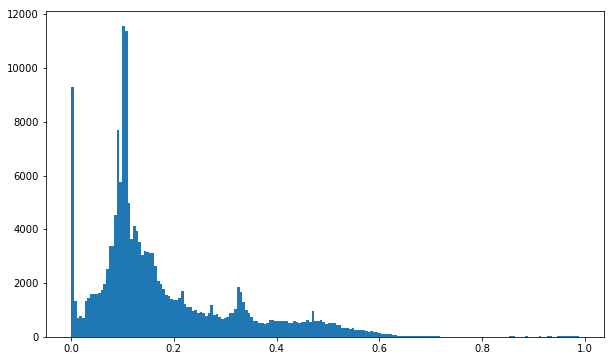

In [19]:
plt.hist(y_pred, bins='auto')

Оставим все как было. Только валидацию будем делать на той части предыдущего набора валидации который более всего похож на данные из лидерборда.

In [20]:
train_adv = df_train.copy()
train_adv['to_valid_choise']=y_pred


X_train = train_adv[:135000]
X_valid = train_adv[135000:]

y_train = target_train[:135000]
y_valid = target_train[135000:]

X_valid = X_valid[(X_valid['to_valid_choise']>=0.35)]

y_train = X_train["isFraud"]
y_valid = X_valid["isFraud"]



X_train = X_train.drop([ "TransactionID", "isFraud", 'to_valid_choise'], axis=1)
X_valid = X_valid.drop([ "TransactionID", "isFraud", 'to_valid_choise'], axis=1)




encoder = ce.HelmertEncoder(cols=category_features)
encoder.fit(X_train, y_train)
train_cleaned = encoder.transform(X_train)
valid_cleaned = encoder.transform(X_valid)

lb_cleaned  = encoder.transform(lb)

dtrain = lgb.Dataset(
    data=train_cleaned, label=y_train
)
dvalid = lgb.Dataset(
    data=valid_cleaned,  label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=50
)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.87937	valid_1's auc: 0.898049
[100]	training's auc: 0.902945	valid_1's auc: 0.907315
[150]	training's auc: 0.91494	valid_1's auc: 0.912492
[200]	training's auc: 0.922286	valid_1's auc: 0.916797
[250]	training's auc: 0.92939	valid_1's auc: 0.918953
[300]	training's auc: 0.937121	valid_1's auc: 0.92104
[350]	training's auc: 0.944002	valid_1's auc: 0.924029
[400]	training's auc: 0.949436	valid_1's auc: 0.925908
[450]	training's auc: 0.954155	valid_1's auc: 0.928421
[500]	training's auc: 0.958298	valid_1's auc: 0.930176
[550]	training's auc: 0.962107	valid_1's auc: 0.932794
[600]	training's auc: 0.965085	valid_1's auc: 0.934155
[650]	training's auc: 0.96766	valid_1's auc: 0.934707
[700]	training's auc: 0.970151	valid_1's auc: 0.935458
[750]	training's auc: 0.97233	valid_1's auc: 0.93603
[800]	training's auc: 0.974234	valid_1's auc: 0.936608
[850]	training's auc: 0.975935	valid_1's auc: 0.93699
[900]	trainin

train_roc_auc: 0.9763607718873222
valid_roc_auc: 0.9370268992260815
lb_roc_auc   : 0.8744691506531785


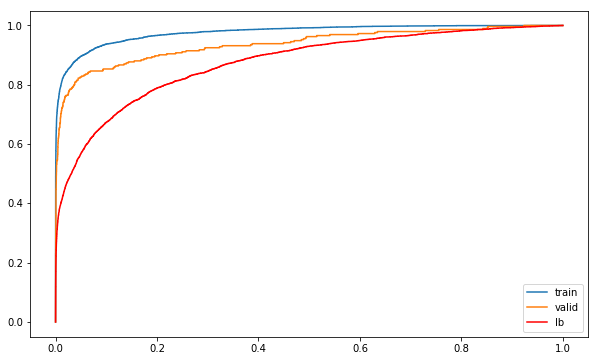

In [21]:
show_results(model, train_cleaned, y_train, valid_cleaned, y_valid, 
                 lb_cleaned, target_lb, test_cleaned = None, y_test = None)

__Выводы:__

Это был сильный ход. Имеем лучший вариант. (__lb_roc_auc   : 0.8744691506531785__)

__Задание 5:__ сделать __KFold / StratifiedKFold__ валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.


In [22]:
target_train = df_train["isFraud"]
target_lb    = lb__board["isFraud"]
train = df_train.drop(["TransactionID", "isFraud"], axis=1)
lb    = lb__board.drop(["TransactionID", "isFraud"], axis=1)
print("train.shape = {} rows, {} cols".format(*train.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))



df_numerical_features = train.select_dtypes(include=[np.number])
numerical_features = df_numerical_features.columns
category_features  = [i for i in train.columns if i not in numerical_features]

train_roc_auc_list = []
valid_roc_auc_list = []
lb_roc_auc_list    = []
test_roc_auc_list    = []

n_splits = 5
cv_strategy = StratifiedKFold(n_splits=n_splits, random_state=12)

X_test  = train[135000:]
y_test  = target_train[135000:]
X=train[:135000]
y=target_train[:135000]

for train_index, test_index in cv_strategy.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    

    encoder = ce.HelmertEncoder(cols=category_features)
    encoder.fit(X_train, y_train)
    train_cleaned = encoder.transform(X_train)
    valid_cleaned = encoder.transform(X_valid)
    test_cleaned  = encoder.transform(X_test)

    lb_cleaned  = encoder.transform(lb)

    dtrain = lgb.Dataset(
        data=train_cleaned, label=y_train
    )
    dvalid = lgb.Dataset(
        data=valid_cleaned,  label=y_valid
    )    


    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=5000, 
        valid_sets=[dtrain, dvalid],
        categorical_feature="auto",
        early_stopping_rounds=50,
        verbose_eval=1000
    )    

    ypred_train = model.predict(train_cleaned)
    ypred_valid = model.predict(valid_cleaned)
    ypred_lb    = model.predict(lb_cleaned )
    ypred_test  = model.predict(test_cleaned )
    
    train_roc_auc = roc_auc_score(y_train, ypred_train)
    valid_roc_auc = roc_auc_score(y_valid, ypred_valid)
    lb_roc_auc    = roc_auc_score(target_lb , ypred_lb)
    test_roc_auc  = roc_auc_score(y_test , ypred_test)    
    
    train_roc_auc_list.append(train_roc_auc)
    valid_roc_auc_list.append(valid_roc_auc)
    lb_roc_auc_list.append(lb_roc_auc)
    test_roc_auc_list.append(test_roc_auc)
    
    
    print('train_roc_auc:', train_roc_auc)
    print('valid_roc_auc:', valid_roc_auc)
    print('test_roc_auc :', test_roc_auc)        
    print('lb_roc_auc   :', lb_roc_auc)
    print('====================================================')
    print()
    

train.shape = 180000 rows, 392 cols
lb.shape = 100001 rows, 392 cols
Training until validation scores don't improve for 50 rounds
[1000]	training's auc: 0.984965	valid_1's auc: 0.893246
Early stopping, best iteration is:
[1064]	training's auc: 0.98615	valid_1's auc: 0.893993
train_roc_auc: 0.9861501764494697
valid_roc_auc: 0.8939926550004595
test_roc_auc : 0.9112538717565548
lb_roc_auc   : 0.8668148299711858

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[373]	training's auc: 0.951025	valid_1's auc: 0.900219
train_roc_auc: 0.95102502220651
valid_roc_auc: 0.9002188408154029
test_roc_auc : 0.8955256418964814
lb_roc_auc   : 0.870836852962977

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	training's auc: 0.946915	valid_1's auc: 0.907963
train_roc_auc: 0.9469145697845731
valid_roc_auc: 0.9079633121239226
test_roc_auc : 0.8933976158130689
lb_roc_auc   : 0.8690017047583535

Training until

In [23]:
train_roc_auc_list = np.array(train_roc_auc_list)
print("train results: max", train_roc_auc_list.max(),"min:", train_roc_auc_list.min(), "mean:", train_roc_auc_list.mean(), "std:", train_roc_auc_list.std())
valid_roc_auc_list = np.array(valid_roc_auc_list)
print("valid results: max", valid_roc_auc_list.max(),"min:", valid_roc_auc_list.min(), "mean:", valid_roc_auc_list.mean(), "std:", valid_roc_auc_list.std())
test_roc_auc_list = np.array(test_roc_auc_list)
print("test results:  max", test_roc_auc_list.max(),"min:", test_roc_auc_list.min(), "mean:", test_roc_auc_list.mean(), "std:", test_roc_auc_list.std())
lb_roc_auc_list = np.array(lb_roc_auc_list)
print("board results: max", lb_roc_auc_list.max(),"min:", lb_roc_auc_list.min(), "mean:", lb_roc_auc_list.mean(), "std:", lb_roc_auc_list.std())


train results: max 0.9929630051827194 min: 0.911491304438973 mean: 0.9577088156124489 std: 0.029492426366355302
valid results: max 0.9161101829477398 min: 0.8772625630927238 mean: 0.8991095107960497 std: 0.013206926984270461
test results:  max 0.9129241543268578 min: 0.8324278223067517 mean: 0.8891058212199429 std: 0.029427464361431045
board results: max 0.870836852962977 min: 0.8274940998278079 mean: 0.8597343730220102 std: 0.016258294672908853


__Выводы:__

Валидация устойчивая.  
Выбросы в значениях отсутствуют.    
Качество на __valid__ выборке лучше чем на __L board__ выборке но хуже чем на __train__.   
Качество на отложенной выборке слегка хуже чем на __valid__. Скорее всего из за неравномерности распределения целевого класса и из за того что сама __valid__ выборка в процессе валидации менялась и ее показатели усреднялись.

Валидация нормальная. Для улучшения качества надо улучшать модель. Надо работать с признаками. Точно надо обработать признак времени транзакции и вытащить от туда переодические изменения по неделям и по дням.

__Задание 6 (опциональное):__ сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

Здесь я не понял в чем различие задания №6 и №1... Там мы разбивали по __TransactionID__ а здесь по __TransactionDT__. Но это две одинаково монотонно возрастающих величины и все равно по какой из них разбивать... И там и здесь разбиение по времени. 

__Задание 7 (совсем опциональное):__ в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [24]:
from sklearn.model_selection import GroupKFold

target_train = df_train["isFraud"]
target_lb    = lb__board["isFraud"]
train = df_train.drop(["TransactionID", "isFraud"], axis=1)
lb    = lb__board.drop(["TransactionID", "isFraud"], axis=1)
print("train.shape = {} rows, {} cols".format(*train.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))


#train['elvis_id']=train['addr1'].astype('str')+train['addr2'].astype('str')       
#lb['elvis_id']=lb['addr1'].astype('str')+lb['addr2'].astype('str')

train['elvis_id']=train['addr1'].astype('str')    
lb['elvis_id']=lb['addr1'].astype('str')

                
train['elvis_id'], _= pd.factorize(train['elvis_id'])
lb['elvis_id'], _= pd.factorize(lb['elvis_id'])
train['elvis_id']= train['elvis_id'].astype('category')
lb['elvis_id']= lb['elvis_id'].astype('category')

        
        
df_numerical_features = train.select_dtypes(include=[np.number])
numerical_features = df_numerical_features.columns
category_features  = [i for i in train.columns if i not in numerical_features]

train_roc_auc_list = []
valid_roc_auc_list = []
lb_roc_auc_list    = []
test_roc_auc_list  = []


X_test  = train[135000:]
y_test  = target_train[135000:]

X=train[:135000]
y=target_train[:135000]

groups = X['elvis_id']
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, groups)


for train_index, test_index in cv_strategy.split(X, y, groups):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    

#    encoder = ce.TargetEncoder(cols=category_features)
    encoder = ce.HelmertEncoder(cols=category_features)
    encoder.fit(X_train, y_train)
    train_cleaned = encoder.transform(X_train)
    valid_cleaned = encoder.transform(X_valid)
    test_cleaned  = encoder.transform(X_test)

    lb_cleaned  = encoder.transform(lb)

    dtrain = lgb.Dataset(
        data=train_cleaned, label=y_train
    )
    dvalid = lgb.Dataset(
        data=valid_cleaned,  label=y_valid
    )    


    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dvalid],
        categorical_feature="auto",
        early_stopping_rounds=50,
        verbose_eval=1000
    )    

    ypred_train = model.predict(train_cleaned)
    ypred_valid = model.predict(valid_cleaned)
    ypred_lb    = model.predict(lb_cleaned )
    ypred_test  = model.predict(test_cleaned )
    
    train_roc_auc = roc_auc_score(y_train, ypred_train)
    valid_roc_auc = roc_auc_score(y_valid, ypred_valid)
    lb_roc_auc    = roc_auc_score(target_lb , ypred_lb)
    test_roc_auc  = roc_auc_score(y_test , ypred_test)    
    
    train_roc_auc_list.append(train_roc_auc)
    valid_roc_auc_list.append(valid_roc_auc)
    lb_roc_auc_list.append(lb_roc_auc)
    test_roc_auc_list.append(test_roc_auc)
    
    
    print('train_roc_auc:', train_roc_auc)
    print('valid_roc_auc:', valid_roc_auc)
    print('test_roc_auc :', test_roc_auc)        
    print('lb_roc_auc   :', lb_roc_auc)
    print('====================================================')
    print()
    

train.shape = 180000 rows, 392 cols
lb.shape = 100001 rows, 392 cols
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	training's auc: 0.928055	valid_1's auc: 0.858246
train_roc_auc: 0.92805454745549
valid_roc_auc: 0.8582457458176302
test_roc_auc : 0.8745540415704387
lb_roc_auc   : 0.8572126684433616

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	training's auc: 0.955776	valid_1's auc: 0.901969
train_roc_auc: 0.9557759723273354
valid_roc_auc: 0.9019694126651913
test_roc_auc : 0.8950433840510801
lb_roc_auc   : 0.8700658519850613

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	training's auc: 0.948275	valid_1's auc: 0.908745
train_roc_auc: 0.9482752404164942
valid_roc_auc: 0.9087449377594095
test_roc_auc : 0.8948028121179187
lb_roc_auc   : 0.8671938415742484

Training until validation scores don't improve for 50 rounds
Early st

In [25]:
train_roc_auc_list = np.array(train_roc_auc_list)
print("train results: max", train_roc_auc_list.max(),"min:", train_roc_auc_list.min(), "mean:", train_roc_auc_list.mean(), "std:", train_roc_auc_list.std())
valid_roc_auc_list = np.array(valid_roc_auc_list)
print("valid results: max", valid_roc_auc_list.max(),"min:", valid_roc_auc_list.min(), "mean:", valid_roc_auc_list.mean(), "std:", valid_roc_auc_list.std())
test_roc_auc_list = np.array(test_roc_auc_list)
print("test results:  max", test_roc_auc_list.max(),"min:", test_roc_auc_list.min(), "mean:", test_roc_auc_list.mean(), "std:", test_roc_auc_list.std())
lb_roc_auc_list = np.array(lb_roc_auc_list)
print("board results: max", lb_roc_auc_list.max(),"min:", lb_roc_auc_list.min(), "mean:", lb_roc_auc_list.mean(), "std:", lb_roc_auc_list.std())


train results: max 0.9841651533503127 min: 0.9152090254739416 mean: 0.9462959878047148 std: 0.02377818588345
valid results: max 0.9160627589675239 min: 0.8582457458176302 mean: 0.8927195741042935 std: 0.021334429701379172
test results:  max 0.9101652900421138 min: 0.8401538377937781 mean: 0.882943873115066 std: 0.0242050182186445
board results: max 0.8700658519850613 min: 0.8307112181302243 mean: 0.8583626766519593 std: 0.014486026675205007


__Выводы:__

Валидация на __GroupKFold__ практически соответствует валидации на __StratifiedKFold.__  
Возможно клиента надо идентифицировать как то по другому...